In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [39]:
MAX_FEATURES = 1000
KFOLD = 10
CLASS_WEIGHT = None # "balanced"
model = LogisticRegression(verbose=True, class_weight=CLASS_WEIGHT)

In [25]:
raw_data = pd.read_csv('/opt/project/data/raw/switchboard_complete.zip')

In [26]:
print(raw_data.shape)
print(raw_data.columns)

(216570, 15)
Index(['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index',
       'act_tag', 'act_label_1', 'act_label_2', 'act_label_relation', 'caller',
       'utterance_index', 'subutterance_index', 'clean_text', 'X',
       'topic_description', 'prompt'],
      dtype='object')


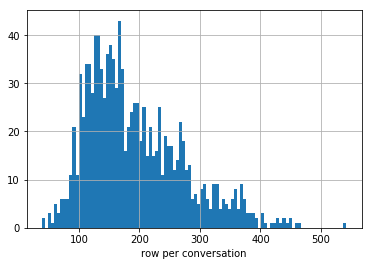

In [27]:
raw_data.groupby('conversation_no').conversation_no.count().hist(bins=100)
plt.xlabel('row per conversation')

In [28]:
raw_data.groupby('act_label_1').agg({'act_label_1': {'count': lambda x: x.count()}, 
                                     'clean_text': {'examples': lambda x:" | ".join(x.iloc[:5])}})\
.sort_values(('act_label_1','count'), ascending=False)

,act_label_1,clean_text
,count,examples
act_label_1,,
Forward-Communicative-Function:Statement:Statement-non-opinion,72365,I think it usually does. | I | It seemed like ...
Backwards-Communicative-Function:Understanding:Acknowledge,37500,Okay | Uh-huh. | Yeah | Uh-huh. | Yeah.
Forward-Communicative-Function:Statement:Statement-opinion,25263,"I guess | but, and they're expensive | take a ..."
Other:Segment-(multi-utterance),18352,"What kind of experience do you, do you have, t..."
Communicative-Status:Uninterpretable,15279,"Yes, uh | Um. | so, but, uh | but | that's"
Backwards-Communicative-Function:Agreement:Accept,10933,Okay. | Okay. | Yeah | Yes. | Yeah
Info-request:Yes-No-Question,5623,I guess | Does it say something ? | Well | do ...
Backwards-Communicative-Function:Understanding:Appreciation,4586,Wow. | How lucky. | Um. Sounds good. | That so...


In [29]:
# computing bag of word - ideally this should be part of a pipeline and used in cross-validation.
# for simplicity and faster computation, I assumed it knows all the data aprioiri
count_vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X = count_vectorizer.fit_transform(raw_data.clean_text.fillna(""))

In [30]:
# labels
is_question = raw_data.act_label_1.str.lower().str.contains('question')
y = is_question==True
is_question.value_counts()

False    206413
True      10121
Name: act_label_1, dtype: int64

In [66]:
# cross validation
cv = StratifiedKFold(n_splits=KFOLD)
prob = []
true = []
grp = []
fold = 0
for train_index, test_index in cv.split(X, y):
    fold += 1
    print('compute kfold = %d/%d'%(fold, KFOLD))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    prob.append(model.predict_proba(X_test)[:,1])
    true.append(y_test)
    grp.append(raw_data.act_label_1[test_index])
#cross_val_score(estimator=LogisticRegressionCV(), X=X, y=y, scoring='roc_auc', verbose=10)

compute kfold = 1/10
[LibLinear]compute kfold = 2/10
[LibLinear]compute kfold = 3/10
[LibLinear]compute kfold = 4/10
[LibLinear]compute kfold = 5/10
[LibLinear]compute kfold = 6/10
[LibLinear]compute kfold = 7/10
[LibLinear]compute kfold = 8/10
[LibLinear]compute kfold = 9/10
[LibLinear]compute kfold = 10/10
[LibLinear]

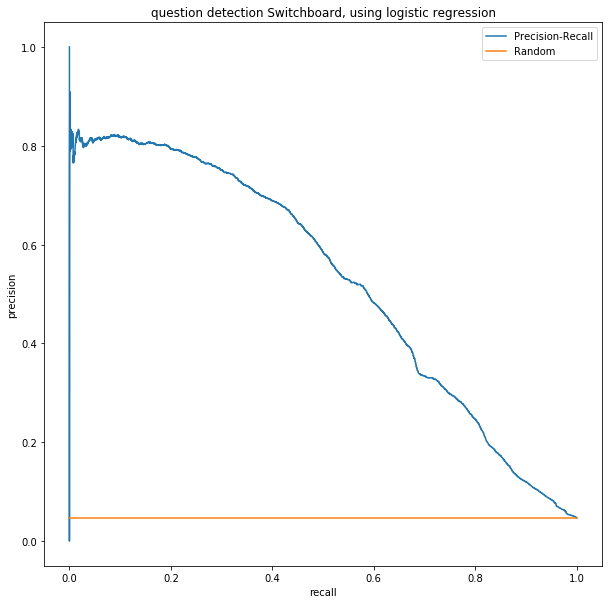

In [68]:
# precision-recall analysis
true = np.hstack(true)
prob = np.hstack(prob)
grp = np.hstack(grp)
precision, recall, thresholds = precision_recall_curve(true, prob)
plt.figure(figsize=(10,10))
plot(recall, precision,label='Precision-Recall')
plot([0, 1], 2*[y.mean()], label='Random')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('question detection Switchboard, using logistic regression')
plt.legend()

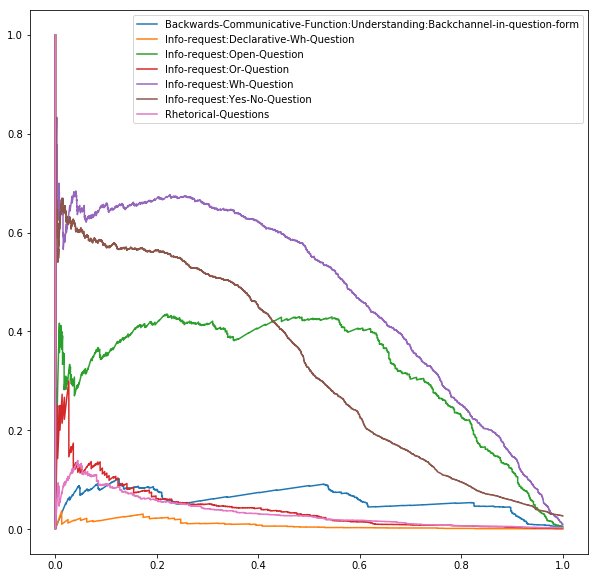

In [73]:
def pr_plot(true, prob, label):
    precision, recall, thresholds = precision_recall_curve(true, prob)
    plot(recall, precision,label=label)

pr = pd.DataFrame({'true': true, 'prob':prob, 'grp':grp})
negative = pr[pr.true==False]
positive = pr[pr.true==True]
plt.figure(figsize=(10,10))
for grp_name, grp_data in positive.groupby('grp'):
    df = pd.concat([negative, grp_data], axis=0)
    pr_plot(df.true, df.prob, grp_name)
plt.legend()

In [33]:
# full model training for coefficient analysis (next)
model.fit(X, y)

max_iter reached after 13 seconds


/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=True, warm_start=False)

In [34]:
# coefficient analysis
inverse_vocabulary = pd.Series({y:x for x,y in count_vectorizer.vocabulary_.items()})
coef = pd.Series(model.coef_.flatten())
word_coef = pd.concat([inverse_vocabulary, coef], axis=1, keys=['word','coef'])
word_coef.sort_values('coef')

,word,coef
204,depends,-4.938639
839,thank,-4.013563
212,doctor,-3.738112
978,worry,-3.574769
21,although,-3.524522
539,months,-3.485372
293,fine,-3.206891
143,check,-3.158664
265,expect,-3.148281
63,basic,-3.133263


In [64]:
# error analysis
pd.options.display.max_colwidth = 200
p_fit = model.predict_proba(X)[:,1]
errors = np.abs(p_fit-y).sort_values(ascending=False).index
pd.DataFrame({'text': raw_data.clean_text.iloc[errors], 'act_label_1':raw_data.act_label_1.iloc[errors], 'label': y.iloc[errors], 'proba': np.round(p_fit[errors],3)})

,act_label_1,label,proba,text
150679,Other:Segment-(multi-utterance),False,1.000,"other issue is, is, is how do you allow, uh, how, how do you allow injustice. Just like the, the policeman in, in Los Angeles"
139834,Info-request:Yes-No-Question,True,0.000,"but if it were told to us that we would find the time somewhere between our seventeenth and, uh, twenty-sixth birthday to give a year or two to the, to the country in the form of maybe building be..."
195766,Info-request:Yes-No-Question,True,0.000,"I'll look at the end because those would be the best ones, okay ?"
42699,Info-request:Yes-No-Question,True,0.000,"they, they each think that, uh, if more people vote, they'll get more votes, huh ?"
53497,Rhetorical-Questions,True,0.000,"because I, you know, if somebody has been convicted and has been sentenced to be put to death, how is it that they can appeal and appeal and appeal and get stays of ex-, execution ?"
167504,Info-request:Yes-No-Question,True,0.000,"See. Well, uh, like in, uh, Iowa and Nebraska, those little bullheads, they look just like catfish, huh ?"
17727,Info-request:Yes-No-Question,True,0.000,"I don't know if you can put some sort of a plastic sheeting or something un-, on, on top of the sand and then lay the bricks."
95,Info-request:Yes-No-Question,True,0.000,"Because after, I guess after he, you know, gets to a certain age she's going to have to take him to a day care."
86407,Info-request:Yes-No-Question,True,0.000,I don't know if maybe I'm biting off more than I can chew.
203244,Info-request:Yes-No-Question,True,0.000,"People from Virginia and, and all over. Yeah."


50